<a href="https://colab.research.google.com/github/vgoyette/nn_deliv_3/blob/main/deliv_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_3_SEC_FILE = '/content/drive/MyDrive/nn-deliv-3/features_3_sec.csv'
DATA_30_SEC_FILE = '/content/drive/MyDrive/nn-deliv-3/features_30_sec.csv'

In [ ]:
df = pd.read_csv(DATA_30_SEC_FILE)
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


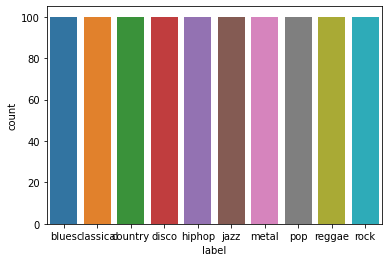

In [ ]:
sns.countplot(x = 'label', data=df)

In [ ]:
label2index = { 'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9 }

index2label = { v: k for k, v in label2index.items() }

In [ ]:
df['label'].replace(label2index, inplace=True)
df = df.drop('filename', axis=1)
df = df.drop('length', axis=1)
df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,0
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,0
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,0
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,0
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,0


In [ ]:
features = df.iloc[:, 0:-1]
labels   = df.iloc[:, -1]
features.head(), labels

(   chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
 0          0.350088         0.088757  0.130228  0.002827   
 1          0.340914         0.094980  0.095948  0.002373   
 2          0.363637         0.085275  0.175570  0.002746   
 3          0.404785         0.093999  0.141093  0.006346   
 4          0.308526         0.087841  0.091529  0.002303   
 
    spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
 0             1784.165850          129774.064525              2002.449060   
 1             1530.176679          375850.073649              2039.036516   
 2             1552.811865          156467.643368              1747.702312   
 3             1070.106615          184355.942417              1596.412872   
 4             1835.004266          343399.939274              1748.172116   
 
    spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_mean  \
 0            85882.761315   3805.839606  9.015054e+05  ...     0.752740   
 1        

In [ ]:
x_train_and_test, x_unknown, y_train_and_test, y_unknown = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=41)

x_train, x_test, y_train, y_test = train_test_split(x_train_and_test, y_train_and_test, test_size=0.25, stratify=y_train_and_test, random_state=76)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_unknown.shape, y_unknown.shape)

(600, 57) (600,)
(200, 57) (200,)
(200, 57) (200,)


In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_unknown = scaler.transform(x_unknown)

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
x_test, y_unknown = np.array(x_unknown), np.array(y_unknown)

In [ ]:
class MusicDataset(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.x_data)

In [ ]:
class MusicMLP(nn.Module):
    def __init__(self, num_features, num_classes):
        super(MusicMLP, self).__init__()
        
        self.input_layer = nn.Linear(num_features, 512)
        self.hidden1 = nn.Linear(512, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, num_classes) 
        
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.hidden1(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        #x = self.dropout(x)
        
        x = self.hidden2(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        #x = self.dropout(x)
        
        x = self.output_layer(x)
        
        return x

In [1]:
def evaluate(model, loader, device):
  model.eval()
  results = 0.0
  #print(len(loader))
  for x_batch, y_batch in loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_pred = model(x_batch)
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, predictions = torch.max(y_pred_softmax, dim = 1)
    #print(y_pred_softmax)
    correct_pred = (predictions == y_batch).float()
    
  return (correct_pred.sum() / len(correct_pred)) * 100

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_dataset   = MusicDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).long())
test_dataset    = MusicDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).long())
unknown_dataset = MusicDataset(torch.from_numpy(x_unknown).float(), torch.from_numpy(y_unknown).long())

cpu


In [ ]:
BATCH_SIZE = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
unknown_loader = DataLoader(dataset=unknown_dataset, batch_size=1)

In [ ]:
NUM_FEATURES = 57
NUM_CLASSES = 10
model = MusicMLP(num_features=NUM_FEATURES, num_classes=NUM_CLASSES)
model.to(device)

MusicMLP(
  (input_layer): Linear(in_features=57, out_features=512, bias=True)
  (hidden1): Linear(in_features=512, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
LEARNING_RATE = 0.001
train_weights = torch.tensor([1./60 for i in range(10)])
criterion = nn.CrossEntropyLoss(weight=train_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
MODE = 'train'
EPOCHS = 25
SAVE_PATH = 'best_model_deliv_3.pth'
train_accs = []
train_losses = []

if MODE == 'train':
  model.train()
  high_acc   = 0.0
  for epoch in range(EPOCHS):
    epoch_loss = 0.0
    epoch_acc  = 0.0

    # Training
    for x_batch, y_batch in train_loader:
      optimizer.zero_grad()

      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      y_pred = model(x_batch)

      loss = criterion(y_pred, y_batch)

      loss.backward()
      optimizer.step()

      acc = evaluate(model, test_loader, device)

      epoch_loss += loss.item()
      epoch_acc  += acc

      if acc > high_acc:
        torch.save(model.state_dict(), SAVE_PATH)

    
    train_accs.append(epoch_acc/len(train_loader))
    train_losses.append(epoch_loss/len(train_loader))
    #if (epoch + 1) % 5 == 0:
    print(f"Epoch #{epoch+1} Training Accuracy: {acc*100:.2f}%, Loss: {loss}")
    break

elif MODE == 'eval':
  model.load_state_dict(torch.load(SAVE_PATH))
  acc = evaluate(model, test_loader, device)
  print(f"Test accuracy = {acc}")




Streaming output truncated to the last 5000 lines.
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])


In [ ]:
model.load_state_dict(torch.load(SAVE_PATH))
acc = evaluate(model, test_loader, device)
print(f"Test accuracy = {acc*100}%")

Test accuracy = 9.0%


In [ ]:
model.load_state_dict(torch.load(SAVE_PATH))
acc = evaluate(model, unknown_loader, device)
print(f"Test accuracy = {acc*100}%")

Test accuracy = 61.0%
